# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run1_limited",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.89037734
Average power, source: 0.99999994


Average magnitude, target: 0.8935504
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 129.5092, train_label_loss: 2.8089, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 3145.1633, train_label_loss: 2.8430, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 3169.0874, train_label_loss: 1.8509, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 3193.5391, train_label_loss: 1.7991, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 3163.4213, train_label_loss: 1.5553, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 3187.5630, train_label_loss: 1.4562, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 3168.3273, train_label_loss: 1.7771, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 3134.9601, train_label_loss: 1.5185, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 3151.4796, train_label_loss: 1.3302, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 3161.5246, train_label_loss: 1.2962, 


epoch: 1, source_val_acc_label: 0.3819, target_val_acc_label: 0.2711, source_val_label_loss: 1.5477, target_val_label_loss: 1.8766, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 11.1265, train_label_loss: 1.6425, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 3152.9267, train_label_loss: 1.3396, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 3163.6245, train_label_loss: 1.1167, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 3170.2271, train_label_loss: 1.4650, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 3157.1881, train_label_loss: 1.4207, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 3179.3435, train_label_loss: 1.4957, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 3178.9239, train_label_loss: 1.1667, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 3167.8040, train_label_loss: 1.3675, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3172.8638, train_label_loss: 1.4819, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 3194.5139, train_label_loss: 1.6692, 


epoch: 2, source_val_acc_label: 0.4218, target_val_acc_label: 0.2996, source_val_label_loss: 1.4503, target_val_label_loss: 1.8137, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 11.1237, train_label_loss: 1.3118, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 3187.5201, train_label_loss: 1.2643, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 3174.3840, train_label_loss: 1.3717, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 3181.3338, train_label_loss: 1.2206, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 3152.3725, train_label_loss: 1.3795, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3159.3426, train_label_loss: 1.5500, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3169.3170, train_label_loss: 1.5156, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3177.3827, train_label_loss: 1.1421, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3174.9509, train_label_loss: 1.2556, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 3169.5086, train_label_loss: 1.0131, 


epoch: 3, source_val_acc_label: 0.4359, target_val_acc_label: 0.3078, source_val_label_loss: 1.4464, target_val_label_loss: 1.8074, 


New best


epoch: 4, [batch: 1 / 2520], examples_per_second: 11.1456, train_label_loss: 1.2449, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 3171.9097, train_label_loss: 1.3484, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 3187.2194, train_label_loss: 1.0955, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3182.0014, train_label_loss: 1.2606, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 3176.0810, train_label_loss: 0.8695, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 3186.9183, train_label_loss: 1.0289, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 3201.5687, train_label_loss: 1.1231, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 3174.2759, train_label_loss: 1.0258, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 3189.7895, train_label_loss: 0.9247, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3181.3638, train_label_loss: 1.0889, 


epoch: 4, source_val_acc_label: 0.5480, target_val_acc_label: 0.4411, source_val_label_loss: 1.2202, target_val_label_loss: 1.5189, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 11.1002, train_label_loss: 0.6514, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 3171.6740, train_label_loss: 0.6504, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 3187.6463, train_label_loss: 0.5578, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 3174.2945, train_label_loss: 1.0498, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 3172.5481, train_label_loss: 0.7519, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 3182.4724, train_label_loss: 0.5230, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 3176.5304, train_label_loss: 0.5120, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 3171.8545, train_label_loss: 0.8821, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 3176.1852, train_label_loss: 0.9014, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 3185.2855, train_label_loss: 0.8812, 


epoch: 5, source_val_acc_label: 0.5656, target_val_acc_label: 0.4597, source_val_label_loss: 1.2491, target_val_label_loss: 1.5215, 


New best


epoch: 6, [batch: 1 / 2520], examples_per_second: 11.0845, train_label_loss: 0.4461, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 3167.5772, train_label_loss: 0.3456, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 3192.9288, train_label_loss: 0.9047, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 3188.4358, train_label_loss: 0.8322, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 3175.1763, train_label_loss: 0.3416, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 3179.5165, train_label_loss: 0.4836, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 3185.3083, train_label_loss: 0.7961, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 3192.6010, train_label_loss: 0.7751, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 3195.4482, train_label_loss: 0.2166, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 3196.1824, train_label_loss: 0.3098, 


epoch: 6, source_val_acc_label: 0.5744, target_val_acc_label: 0.4830, source_val_label_loss: 1.3265, target_val_label_loss: 1.5741, 


New best


epoch: 7, [batch: 1 / 2520], examples_per_second: 11.1122, train_label_loss: 0.6298, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 3151.1534, train_label_loss: 0.5392, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3174.5659, train_label_loss: 0.7182, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3182.0559, train_label_loss: 0.3757, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3160.7522, train_label_loss: 0.5143, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 3172.5570, train_label_loss: 0.8393, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 3183.4760, train_label_loss: 0.2695, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 3167.3333, train_label_loss: 0.5389, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 3205.1929, train_label_loss: 0.3491, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 3181.2142, train_label_loss: 0.5804, 


epoch: 7, source_val_acc_label: 0.5804, target_val_acc_label: 0.4870, source_val_label_loss: 1.3764, target_val_label_loss: 1.6486, 


New best


epoch: 8, [batch: 1 / 2520], examples_per_second: 11.1222, train_label_loss: 0.4127, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3157.5816, train_label_loss: 0.3194, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3181.3872, train_label_loss: 0.5630, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3184.1868, train_label_loss: 0.4101, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3176.0832, train_label_loss: 0.4026, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 3181.8576, train_label_loss: 0.2275, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 3186.1710, train_label_loss: 0.3533, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 3154.1373, train_label_loss: 0.1803, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 3170.1602, train_label_loss: 0.3168, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3185.8068, train_label_loss: 0.6416, 


epoch: 8, source_val_acc_label: 0.5857, target_val_acc_label: 0.4853, source_val_label_loss: 1.4683, target_val_label_loss: 1.7626, 


epoch: 9, [batch: 1 / 2520], examples_per_second: 11.1848, train_label_loss: 0.5487, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3163.1552, train_label_loss: 0.3050, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 3181.2461, train_label_loss: 0.4637, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 3180.0930, train_label_loss: 0.2988, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 3170.8896, train_label_loss: 0.4386, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 3178.8698, train_label_loss: 0.3694, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 3172.1801, train_label_loss: 0.2180, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 3148.1199, train_label_loss: 0.4193, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 3168.5231, train_label_loss: 0.3183, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3194.8364, train_label_loss: 0.2857, 


epoch: 9, source_val_acc_label: 0.5910, target_val_acc_label: 0.4895, source_val_label_loss: 1.5133, target_val_label_loss: 1.7959, 


New best


epoch: 10, [batch: 1 / 2520], examples_per_second: 11.1689, train_label_loss: 0.3533, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 3176.6787, train_label_loss: 0.4292, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 3196.1498, train_label_loss: 0.4456, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 3186.3325, train_label_loss: 0.3525, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 3168.6427, train_label_loss: 0.3818, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 3183.8442, train_label_loss: 0.2182, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 3197.1938, train_label_loss: 0.1629, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3183.9111, train_label_loss: 0.0259, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3182.3366, train_label_loss: 0.1116, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3178.3011, train_label_loss: 0.6485, 


epoch: 10, source_val_acc_label: 0.5868, target_val_acc_label: 0.4848, source_val_label_loss: 1.6356, target_val_label_loss: 1.9358, 


epoch: 11, [batch: 1 / 2520], examples_per_second: 11.1344, train_label_loss: 0.1490, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 3173.5237, train_label_loss: 0.0169, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 3187.2630, train_label_loss: 0.1749, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 3181.9352, train_label_loss: 0.1211, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 3161.8825, train_label_loss: 0.1872, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 3160.2268, train_label_loss: 0.2583, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 3162.4725, train_label_loss: 0.0625, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 3167.3552, train_label_loss: 0.4917, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 3170.9774, train_label_loss: 0.0508, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 3181.9747, train_label_loss: 0.3241, 


epoch: 11, source_val_acc_label: 0.5832, target_val_acc_label: 0.4871, source_val_label_loss: 1.7150, target_val_label_loss: 1.9936, 


epoch: 12, [batch: 1 / 2520], examples_per_second: 11.2072, train_label_loss: 0.6413, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 3164.9775, train_label_loss: 0.4999, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 3168.9126, train_label_loss: 0.0468, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 3175.9741, train_label_loss: 0.1167, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 3154.8172, train_label_loss: 0.1420, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 3185.2176, train_label_loss: 0.0365, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 3183.2086, train_label_loss: 0.1546, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 3160.5260, train_label_loss: 0.3269, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 3209.6436, train_label_loss: 0.1343, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 3187.3277, train_label_loss: 0.0101, 


epoch: 12, source_val_acc_label: 0.5851, target_val_acc_label: 0.4863, source_val_label_loss: 1.8119, target_val_label_loss: 2.1150, 


epoch: 13, [batch: 1 / 2520], examples_per_second: 11.1428, train_label_loss: 0.0780, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 3163.4942, train_label_loss: 0.0055, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 3189.6843, train_label_loss: 0.0681, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 3204.8873, train_label_loss: 0.1845, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 3178.5780, train_label_loss: 0.0708, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 3179.6575, train_label_loss: 0.0207, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 3192.0498, train_label_loss: 0.5922, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 3169.0242, train_label_loss: 0.1108, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 3161.4397, train_label_loss: 0.0298, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 3171.8451, train_label_loss: 0.3375, 


epoch: 13, source_val_acc_label: 0.5857, target_val_acc_label: 0.4924, source_val_label_loss: 1.8530, target_val_label_loss: 2.1807, 


New best


epoch: 14, [batch: 1 / 2520], examples_per_second: 11.2009, train_label_loss: 0.2252, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 3152.6791, train_label_loss: 0.0032, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 3157.2069, train_label_loss: 0.1941, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 3178.5490, train_label_loss: 0.0238, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 3148.2503, train_label_loss: 0.1622, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 3177.3040, train_label_loss: 0.2801, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 3185.8080, train_label_loss: 0.2005, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 3172.3657, train_label_loss: 0.0517, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 3166.1141, train_label_loss: 0.1101, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 3150.6997, train_label_loss: 0.1487, 


epoch: 14, source_val_acc_label: 0.5799, target_val_acc_label: 0.4936, source_val_label_loss: 1.8987, target_val_label_loss: 2.2100, 


New best


epoch: 15, [batch: 1 / 2520], examples_per_second: 11.1096, train_label_loss: 0.1733, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 3153.2583, train_label_loss: 0.0663, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 3171.0648, train_label_loss: 0.2505, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 3184.8895, train_label_loss: 0.0347, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 3177.6929, train_label_loss: 0.1015, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 3168.5140, train_label_loss: 0.0164, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 3165.7286, train_label_loss: 0.2927, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 3175.6984, train_label_loss: 0.0096, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 3181.0769, train_label_loss: 0.1186, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 3192.8214, train_label_loss: 0.2033, 


epoch: 15, source_val_acc_label: 0.5852, target_val_acc_label: 0.4919, source_val_label_loss: 1.9209, target_val_label_loss: 2.2663, 


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.1726, train_label_loss: 0.2321, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 3153.9266, train_label_loss: 0.2398, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 3160.7040, train_label_loss: 0.0067, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 3166.6596, train_label_loss: 0.1768, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 3173.7078, train_label_loss: 0.0833, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 3194.9688, train_label_loss: 0.0544, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 3175.2905, train_label_loss: 0.2475, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 3170.2244, train_label_loss: 0.3975, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 3168.7670, train_label_loss: 0.0041, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 3176.8803, train_label_loss: 0.1403, 


epoch: 16, source_val_acc_label: 0.5844, target_val_acc_label: 0.4919, source_val_label_loss: 1.9634, target_val_label_loss: 2.3111, 


epoch: 17, [batch: 1 / 2520], examples_per_second: 11.1979, train_label_loss: 0.0398, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 3150.2640, train_label_loss: 0.2911, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 3194.7525, train_label_loss: 0.0634, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 3185.4361, train_label_loss: 0.2204, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 3168.7757, train_label_loss: 0.3015, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 3178.3728, train_label_loss: 0.0696, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 3166.9661, train_label_loss: 0.3925, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 3168.8400, train_label_loss: 0.0285, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 3181.3736, train_label_loss: 0.1529, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 3180.6632, train_label_loss: 0.3347, 


epoch: 17, source_val_acc_label: 0.5847, target_val_acc_label: 0.4942, source_val_label_loss: 2.0616, target_val_label_loss: 2.4334, 


New best


epoch: 18, [batch: 1 / 2520], examples_per_second: 10.9576, train_label_loss: 0.1342, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 3165.0949, train_label_loss: 0.1210, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 3188.9944, train_label_loss: 0.1520, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 3194.0284, train_label_loss: 0.2240, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 3176.4728, train_label_loss: 0.1610, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 3195.2257, train_label_loss: 0.0095, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 3187.2125, train_label_loss: 0.1687, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 3157.2549, train_label_loss: 0.0391, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 3185.6640, train_label_loss: 0.2784, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 3203.4697, train_label_loss: 0.1452, 


epoch: 18, source_val_acc_label: 0.5848, target_val_acc_label: 0.4824, source_val_label_loss: 2.0991, target_val_label_loss: 2.4785, 


epoch: 19, [batch: 1 / 2520], examples_per_second: 11.2282, train_label_loss: 0.4088, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 3174.3062, train_label_loss: 0.0539, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 3179.4680, train_label_loss: 0.0381, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 3198.9517, train_label_loss: 0.0996, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 3176.9825, train_label_loss: 0.1376, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 3180.1285, train_label_loss: 0.1278, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 3177.2204, train_label_loss: 0.1396, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 3177.7833, train_label_loss: 0.0837, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 3203.7009, train_label_loss: 0.0039, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 3190.9721, train_label_loss: 0.0357, 


epoch: 19, source_val_acc_label: 0.5849, target_val_acc_label: 0.4959, source_val_label_loss: 2.1545, target_val_label_loss: 2.5244, 


New best


epoch: 20, [batch: 1 / 2520], examples_per_second: 11.0450, train_label_loss: 0.0194, 


epoch: 20, [batch: 252 / 2520], examples_per_second: 3153.8767, train_label_loss: 0.1096, 


epoch: 20, [batch: 504 / 2520], examples_per_second: 3162.8716, train_label_loss: 0.0191, 


epoch: 20, [batch: 756 / 2520], examples_per_second: 3164.2997, train_label_loss: 0.1948, 


epoch: 20, [batch: 1008 / 2520], examples_per_second: 3161.3846, train_label_loss: 0.0877, 


epoch: 20, [batch: 1260 / 2520], examples_per_second: 3193.6174, train_label_loss: 0.2190, 


epoch: 20, [batch: 1512 / 2520], examples_per_second: 3172.0218, train_label_loss: 0.1425, 


epoch: 20, [batch: 1764 / 2520], examples_per_second: 3161.5830, train_label_loss: 0.0761, 


epoch: 20, [batch: 2016 / 2520], examples_per_second: 3168.7449, train_label_loss: 0.0530, 


epoch: 20, [batch: 2268 / 2520], examples_per_second: 3180.6190, train_label_loss: 0.0749, 


epoch: 20, source_val_acc_label: 0.5781, target_val_acc_label: 0.4913, source_val_label_loss: 2.1481, target_val_label_loss: 2.5010, 


epoch: 21, [batch: 1 / 2520], examples_per_second: 11.0901, train_label_loss: 0.2127, 


epoch: 21, [batch: 252 / 2520], examples_per_second: 3144.1484, train_label_loss: 0.1177, 


epoch: 21, [batch: 504 / 2520], examples_per_second: 3160.6868, train_label_loss: 0.0384, 


epoch: 21, [batch: 756 / 2520], examples_per_second: 3157.8552, train_label_loss: 0.2518, 


epoch: 21, [batch: 1008 / 2520], examples_per_second: 3143.4310, train_label_loss: 0.0304, 


epoch: 21, [batch: 1260 / 2520], examples_per_second: 3155.8463, train_label_loss: 0.2062, 


epoch: 21, [batch: 1512 / 2520], examples_per_second: 3151.0787, train_label_loss: 0.0095, 


epoch: 21, [batch: 1764 / 2520], examples_per_second: 3152.9351, train_label_loss: 0.0568, 


epoch: 21, [batch: 2016 / 2520], examples_per_second: 3173.6930, train_label_loss: 0.0971, 


epoch: 21, [batch: 2268 / 2520], examples_per_second: 3173.9389, train_label_loss: 0.0626, 


epoch: 21, source_val_acc_label: 0.5784, target_val_acc_label: 0.4999, source_val_label_loss: 2.1744, target_val_label_loss: 2.5133, 


New best


epoch: 22, [batch: 1 / 2520], examples_per_second: 11.0775, train_label_loss: 0.0881, 


epoch: 22, [batch: 252 / 2520], examples_per_second: 3170.4499, train_label_loss: 0.0380, 


epoch: 22, [batch: 504 / 2520], examples_per_second: 3181.8644, train_label_loss: 0.2351, 


epoch: 22, [batch: 756 / 2520], examples_per_second: 3189.4587, train_label_loss: 0.0512, 


epoch: 22, [batch: 1008 / 2520], examples_per_second: 3176.7829, train_label_loss: 0.0572, 


epoch: 22, [batch: 1260 / 2520], examples_per_second: 3192.1300, train_label_loss: 0.0174, 


epoch: 22, [batch: 1512 / 2520], examples_per_second: 3193.1772, train_label_loss: 0.1330, 


epoch: 22, [batch: 1764 / 2520], examples_per_second: 3157.4601, train_label_loss: 0.1353, 


epoch: 22, [batch: 2016 / 2520], examples_per_second: 3189.5048, train_label_loss: 0.0453, 


epoch: 22, [batch: 2268 / 2520], examples_per_second: 3178.1619, train_label_loss: 0.0413, 


epoch: 22, source_val_acc_label: 0.5836, target_val_acc_label: 0.4956, source_val_label_loss: 2.1813, target_val_label_loss: 2.4716, 


epoch: 23, [batch: 1 / 2520], examples_per_second: 11.1600, train_label_loss: 0.2772, 


epoch: 23, [batch: 252 / 2520], examples_per_second: 3153.9540, train_label_loss: 0.1114, 


epoch: 23, [batch: 504 / 2520], examples_per_second: 3179.0442, train_label_loss: 0.1770, 


epoch: 23, [batch: 756 / 2520], examples_per_second: 3178.3336, train_label_loss: 0.1678, 


epoch: 23, [batch: 1008 / 2520], examples_per_second: 3158.5081, train_label_loss: 0.0026, 


epoch: 23, [batch: 1260 / 2520], examples_per_second: 3181.0390, train_label_loss: 0.1765, 


epoch: 23, [batch: 1512 / 2520], examples_per_second: 3168.4075, train_label_loss: 0.0301, 


epoch: 23, [batch: 1764 / 2520], examples_per_second: 3162.9824, train_label_loss: 0.0061, 


epoch: 23, [batch: 2016 / 2520], examples_per_second: 3177.0834, train_label_loss: 0.0495, 


epoch: 23, [batch: 2268 / 2520], examples_per_second: 3203.5028, train_label_loss: 0.0625, 


epoch: 23, source_val_acc_label: 0.5837, target_val_acc_label: 0.4931, source_val_label_loss: 2.2316, target_val_label_loss: 2.5713, 


epoch: 24, [batch: 1 / 2520], examples_per_second: 11.1813, train_label_loss: 0.0160, 


epoch: 24, [batch: 252 / 2520], examples_per_second: 3148.8971, train_label_loss: 0.0217, 


epoch: 24, [batch: 504 / 2520], examples_per_second: 3168.5779, train_label_loss: 0.0200, 


epoch: 24, [batch: 756 / 2520], examples_per_second: 3176.6500, train_label_loss: 0.0041, 


epoch: 24, [batch: 1008 / 2520], examples_per_second: 3168.5840, train_label_loss: 0.0597, 


epoch: 24, [batch: 1260 / 2520], examples_per_second: 3188.2208, train_label_loss: 0.0726, 


epoch: 24, [batch: 1512 / 2520], examples_per_second: 3194.9687, train_label_loss: 0.0021, 


epoch: 24, [batch: 1764 / 2520], examples_per_second: 3185.8092, train_label_loss: 0.1282, 


epoch: 24, [batch: 2016 / 2520], examples_per_second: 3190.9149, train_label_loss: 0.0131, 


epoch: 24, [batch: 2268 / 2520], examples_per_second: 3183.9363, train_label_loss: 0.2751, 


epoch: 24, source_val_acc_label: 0.5831, target_val_acc_label: 0.4946, source_val_label_loss: 2.2000, target_val_label_loss: 2.5622, 


epoch: 25, [batch: 1 / 2520], examples_per_second: 11.1830, train_label_loss: 0.0094, 


epoch: 25, [batch: 252 / 2520], examples_per_second: 3188.6429, train_label_loss: 0.0219, 


epoch: 25, [batch: 504 / 2520], examples_per_second: 3173.3526, train_label_loss: 0.1726, 


epoch: 25, [batch: 756 / 2520], examples_per_second: 3193.9473, train_label_loss: 0.2768, 


epoch: 25, [batch: 1008 / 2520], examples_per_second: 3171.2836, train_label_loss: 0.0388, 


epoch: 25, [batch: 1260 / 2520], examples_per_second: 3193.1277, train_label_loss: 0.2885, 


epoch: 25, [batch: 1512 / 2520], examples_per_second: 3182.0446, train_label_loss: 0.0190, 


epoch: 25, [batch: 1764 / 2520], examples_per_second: 3165.1937, train_label_loss: 0.0334, 


epoch: 25, [batch: 2016 / 2520], examples_per_second: 3174.9819, train_label_loss: 0.0275, 


epoch: 25, [batch: 2268 / 2520], examples_per_second: 3184.1037, train_label_loss: 0.0074, 


epoch: 25, source_val_acc_label: 0.5827, target_val_acc_label: 0.4983, source_val_label_loss: 2.2878, target_val_label_loss: 2.6412, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

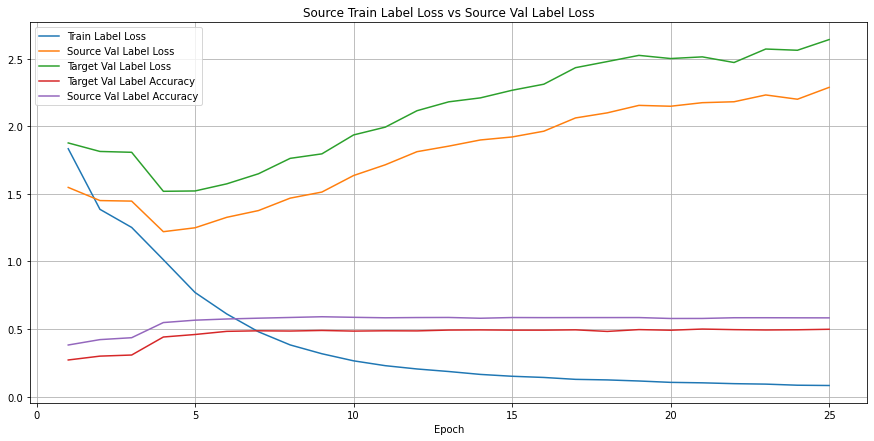

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

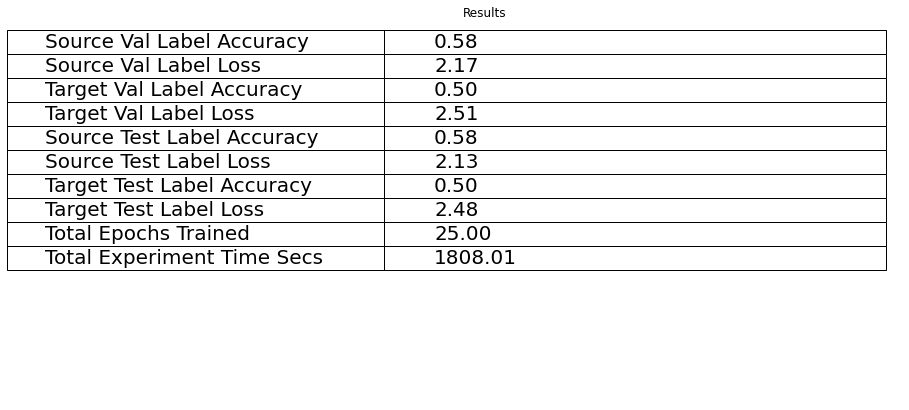

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

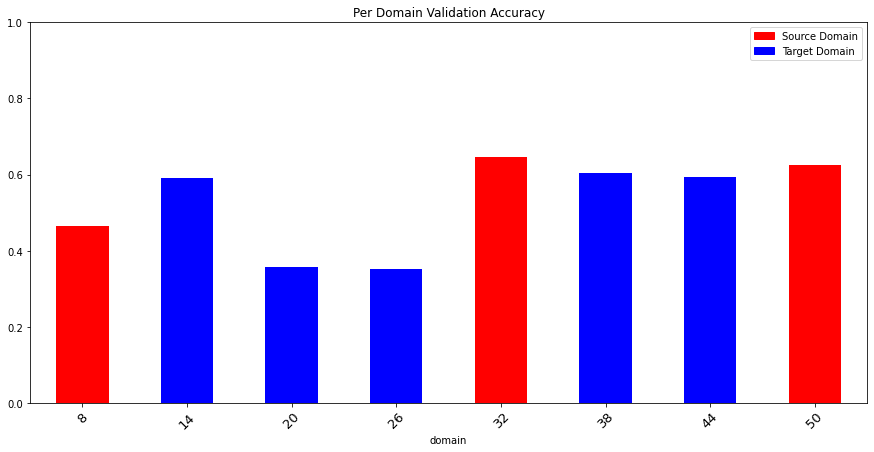

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5798611111111112 Target Test Label Accuracy: 0.49859375
Source Val Label Accuracy: 0.5783854166666667 Target Val Label Accuracy: 0.49994791666666666


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run1_limited", "parameters": {"experiment_name": "tuned_1v2:oracle.run1_limited", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [